In [1]:
# Importing libraries
from random import sample
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from umap import UMAP
from sklearn.metrics import auc, roc_auc_score, roc_curve
pd.set_option('display.max_columns', 200)
%matplotlib inline

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Loading the dataset
data = pd.read_csv('training_v2.csv')

## Data Preprocessing
### Class Imbalance
We find that this dataset is hugely imbalanced. There are very few observations of `hospital_death` = 1 as compared to `hospital_death` = 0. Once presented with previously unseen data, this can prove to be a problem since classification algorithms might classify all the entries as `hospital_death` = 0 in order to obtain a high accuracy. 

In [3]:
# Extracting the counts for each level of the target feature
data['hospital_death'].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

### Resampling 

Resampling, as the name suggests, allows us to obtain a different sample of the data so as to ensure that both classes in our target variable are evenly distributed. Since we have almost 100,000 records in the dataset, we choose **downsampling technique** so that our dataset is reduced to something more manageable thereby also speeding up our first iteration of modeling. 

In [4]:
# Extracting the rows where hospital == 0
alive_data = data[data['hospital_death'] == 0].reset_index(drop=True)

# Generating indexes from 0 to 83798
idx = list(range(0,83798))

# Subset a sample without replacement from the indexes
random.seed(42)
subset = sample(idx, 7915)

# Subsetting the alive_data with the chosen indexes, reseting the index
alive_data = alive_data.loc[subset].reset_index(drop=True)

In [5]:
# Appending the alive_data with the observations where hospital_death == 1
new_data = alive_data.append(data[data['hospital_death'] == 1])

# Shuffling the dataset so the distribution of 0 and 1 is random throughout the dataset
new_data = new_data.sample(frac=1).reset_index(drop=True)

In [6]:
new_data.shape

(15830, 186)

In [7]:
new_data.head(20)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,29797,47132,158,0,79.0,29.936155,0,Caucasian,F,165.1,NaN,Floor,836,transfer,Med-Surg ICU,0.106944,0,81.60,NaN,113.0,501.05,0,0.0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,169.0,127.0,NaN,0.0,48.0,NaN,NaN,NaN,NaN,38.0,NaN,38.90,NaN,0.0,NaN,NaN,NaN,61.0,30.0,61.0,30.0,125.0,114.0,NaN,NaN,72.0,48.0,72.0,48.0,38.0,15.0,99.0,89.0,NaN,NaN,131.0,95.0,131.0,95.0,38.90,37.60,NaN,NaN,51.0,46.0,51.0,46.0,125.0,123.0,NaN,NaN,68.0,64.0,68.0,64.0,23.0,19.0,96.0,89.0,NaN,NaN,131.0,119.0,131.0,119.0,37.60,37.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,169.0,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9,1.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.04,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Sepsis,Cardiovascular
1,66161,5101,194,1,82.0,29.470435,0,African American,M,163.0,Emergency Department,Floor,609,admit,SICU,22.580556,0,78.

### Split the feature variables and the target variable

In [8]:
X = new_data.drop('hospital_death', axis = 1)
y = new_data['hospital_death']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15830 entries, 0 to 15829
Columns: 185 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(7), object(8)
memory usage: 22.3+ MB


### Missing values
This dataset contains a lot of missing values and we've employed various strategies throughout the notebook to deal with them. We first start with: 
1. **Drop rows that contain missing values greater than a 50% threshold.**
2. **Use the index of the rows in step 1 to drop the respective values from the target variable column.**

In [9]:
# Look at the row-wise percentage of missing values in X
X.isnull().mean(axis = 1)

0        0.529730
1        0.281081
2        0.405405
3        0.545946
4        0.545946
5        0.400000
6        0.324324
7        0.340541
8        0.232432
9        0.318919
10       0.313514
11       0.135135
12       0.329730
13       0.237838
14       0.345946
15       0.508108
16       0.302703
17       0.324324
18       0.264865
19       0.318919
20       0.356757
21       0.221622
22       0.351351
23       0.432432
24       0.329730
25       0.416216
26       0.383784
27       0.248649
28       0.302703
29       0.351351
           ...   
15800    0.237838
15801    0.362162
15802    0.362162
15803    0.286486
15804    0.378378
15805    0.227027
15806    0.362162
15807    0.232432
15808    0.545946
15809    0.232432
15810    0.345946
15811    0.432432
15812    0.102703
15813    0.400000
15814    0.259459
15815    0.464865
15816    0.362162
15817    0.194595
15818    0.270270
15819    0.356757
15820    0.086486
15821    0.243243
15822    0.383784
15823    0.443243
15824    0

In [10]:
# Obtaining the index values of rows where 50% or more of the data is missing
idx = X.index[X.isnull().mean(axis=1) > 0.5].tolist()

# Dropping rows from X
row_majority_X = X.drop(X.index[idx]).reset_index(drop=True)
print("The shape of X after dropping rows is {}".format(row_majority_X.shape))

# Dropping corresponding rows from y
final_y = y.drop(y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

The shape of X after dropping rows is (14636, 185)
The shape of y after dropping rows is (14636,)


### Feature Selection

We follow 2 strategies in order to reduce the number of dimensions in our dataset.
1. **Drop columns that contain missing values greater than a 75% threshold:**
> For example, the column `h1_pao2fio2ratio_min` is missing 83.5% of its data. 
2. **Drop coloumns based on manual evaluation of the data:**
> For example, drop the `id` columns since they don't provide any relevant information in predicting `hospital_death`.
> Drop the `height` and `weight` columns since they are collinear to the `bmi` column.
> Drop the `readmission_status` column since it contains all 0s. 

In [11]:
# Look at the column-wise percentage of missing values in X
row_majority_X.isnull().mean()

encounter_id                     0.000000
patient_id                       0.000000
hospital_id                      0.000000
age                              0.055411
bmi                              0.037442
elective_surgery                 0.000000
ethnicity                        0.013870
gender                           0.000410
height                           0.015646
hospital_admit_source            0.223968
icu_admit_source                 0.001093
icu_id                           0.000000
icu_stay_type                    0.000000
icu_type                         0.000000
pre_icu_los_days                 0.000000
readmission_status               0.000000
weight                           0.027603
albumin_apache                   0.503895
apache_2_diagnosis               0.010180
apache_3j_diagnosis              0.006901
apache_post_operative            0.000000
arf_apache                       0.004031
bilirubin_apache                 0.552952
bun_apache                       0

In [12]:
# Retain only those columns where missing values are less than 75%
column_majority_X = row_majority_X[row_majority_X.columns[row_majority_X.isnull().mean() < 0.75]]
column_majority_X.shape

(14636, 149)

In [13]:
# Drop columns based on manual evaluation of data
final_X = column_majority_X.drop(columns=['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'height', 'weight', 'readmission_status'], axis=1)
print("The shape of X after dropping columns is {}".format(final_X.shape))

The shape of X after dropping columns is (14636, 142)


### Feature Transformation
1. **Transforming `BMI` from a numerical to a categorical variable**

BMI Categories | BMI Values
--- | ---
Underweight | <18.5 =0
Normal weight | 18.5–24.9 =1
Overweight | 25–29.9 =2
Obesity | BMI of 30 or greater =3

2. **Transforming `pre_icu_los_days` from a numerical to a categorical variable**

pre_icu_los_days Categories | pre_icu_los_days Values
--- | ---
'0' | <= 0
'1' | > 0 and <= 5
'2' | > 5 and <= 10
'3' | > 10 and <= 15
'4' | > 15 and <= 20
'5' | > 20 and <= 25
'6' | > 25 and <= 30
'7' | => 30

In [14]:
# Transforming BMI to a categorical variable
def BMICat(x) :
    try :
        x = float(x)
        if (x >= 0) and (x < 18.5) : return 'Underweight'
        elif ((x >= 18.5 ) and (x <= 24.9)) : return 'Normal Weight'
        elif ((x >= 25 )   and (x <= 29.9)) : return 'Overweight'
        else : return 'Obese'
    except ValueError:
        return 'Other'

final_X['bmi'] = final_X['bmi'].apply(BMICat)

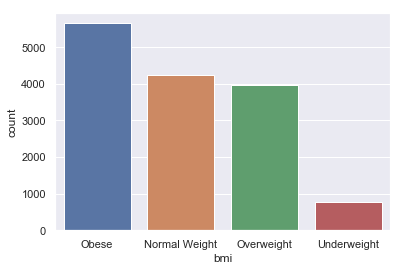

In [15]:
sns.set(style="darkgrid")
ax = sns.countplot(final_X['bmi'], order = final_X['bmi'].value_counts().index)
plt.show()

In [16]:
# Transforming pre_icu_los_days to a categorical variable
def PILDCat(x) :
    try :
        x = float(x)
        if (x <= 0)                : return 'Range[- to 0]'
        elif (x > 0) and (x <= 5) : return  'Range[1 to 5]'
        elif (x > 5) and (x <= 10) : return 'Range[5 to 10]'
        elif (x > 10) and (x <= 15) : return 'Range[11 to 15]'
        elif ((x > 15) and (x <= 20)) : return 'Range[16 to 20]'
        elif ((x > 20) and (x <= 25)) : return 'Range[21 to 25]'
        elif ((x > 25 ) and (x <= 30)) : return 'Range[25 to 30]'
               
        else : return 'Range[> 30]'
    except ValueError:
        return 'Other'

final_X['pre_icu_los_days']= final_X['pre_icu_los_days'].apply(PILDCat)

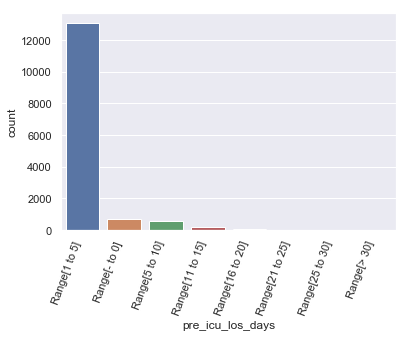

In [17]:
sns.set(style="darkgrid")
ax = sns.countplot(final_X['pre_icu_los_days'], order = final_X['pre_icu_los_days'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

### Split categorical and numerical variables

In [18]:
def num_cat_col(df):
    '''
    Splits the columns of the dataframe into categorical and numerical columns 
    and returns them as 2 separate lists.
    Columns having binary values (0 or 1) are added to the list of categorical columns.
    '''
    num_col = []
    cat_col = []
    dictionary = pd.read_csv('WiDS Datathon 2020 Dictionary.csv')
    new_dictionary = dictionary[dictionary['Data Type'] == 'binary']
    
    for column in df.columns:
        if df[column].dtypes == 'object':
            cat_col.append(column)
        elif column in [value for key, value in new_dictionary['Variable Name'].iteritems()]:
            cat_col.append(column)
        else:
            num_col.append(column)
    return cat_col, num_col

cat_col, num_col = num_cat_col(final_X)

### Dealing with categorical variables

There are still some missing values that need to be taken care of among our categorical variables so we evaluate them in order:
1. **ethnicity** 
> Impute the missing values with 'Other/Unknown' since the dataframe already has that value.
2. **gender** 
> We observe that there are only 6 missing values. Therefore, we decide to impute values as either 'M' or 'F' based on the percentage of these 2 classes in the column. Following that, we encode the values as follows:

Value | Encoding
--- | ---
'F' | 0
'M' | 1

3. **hospital_admit_source** and **icu_admit_source**
> On evaluating the 2 columns side by side, we find that `icu_admit_source` is conveying similar information as `hospital_admit_source` and also has fewer missing values than `hospital_admit_source`. Therefore we decide to drop `hospital_admit_source` and impute the missing values of `icu_admit_source` wuth 'Unknown'.
4. **apache_3j_bodysystem** and **apache_2_bodysystem** 
> On evaluating the 2 columns side by side, we find that `apache_3j_bodysystem` is conveying similar information as `apache_2_bodysystem`. Therefore we decide to drop `apache_2_bodysystem` and impute the missing values of `apache_3j_bodysystem` with 'Unknown'.
5. **arf_apache, intubated_apache, ventilated_apache, aids, cirrhosis, diabetes_mellitus, hepatic_failure         immunosuppression, leukemia, lymphoma, solid_tumor_with_metastasis**
> Upon observation, all these variables have missing values in the same records and hence we drop those records (using the index values) from X_cat, X_num and final_y. 
6. **gcs_unable_apache** 
> This variable tells us whether the Glasgow Coma Scale was unable to be assessed due to patient sedation and is dropped because this information has already been taken care of by 3 other columns - `gcs_eyes_apache`, `gcs_motor_apache` and `gcs_verbal_apache`. 

In [19]:
X_cat = final_X[cat_col]
X_cat.isnull().sum()

bmi                               0
elective_surgery                  0
ethnicity                       203
gender                            6
hospital_admit_source          3278
icu_admit_source                 16
icu_stay_type                     0
icu_type                          0
pre_icu_los_days                  0
apache_post_operative             0
arf_apache                       59
gcs_unable_apache                89
intubated_apache                 59
ventilated_apache                59
aids                             59
cirrhosis                        59
diabetes_mellitus                59
hepatic_failure                  59
immunosuppression                59
leukemia                         59
lymphoma                         59
solid_tumor_with_metastasis      59
apache_3j_bodysystem            149
apache_2_bodysystem             149
dtype: int64

In [20]:
# Value counts for ethnicity
print('The value counts for ethnicity are: \n{}'.format(X_cat['ethnicity'].value_counts()))

The value counts for ethnicity are: 
Caucasian           11324
African American     1490
Other/Unknown         667
Hispanic              624
Asian                 194
Native American       134
Name: ethnicity, dtype: int64


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


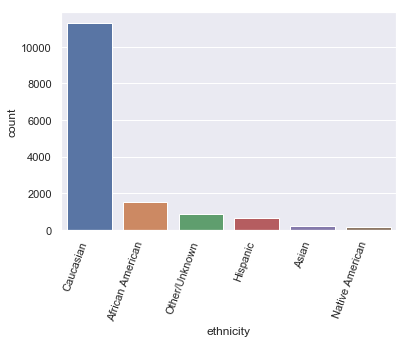

In [21]:
# Imputing values for ethnicity
X_cat.loc[:, 'ethnicity'] = X_cat['ethnicity'].fillna('Other/Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['ethnicity'], order = X_cat['ethnicity'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [22]:
# Percentage of gender classes
X_cat['gender'].value_counts(normalize=True)

M    0.540602
F    0.459398
Name: gender, dtype: float64

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


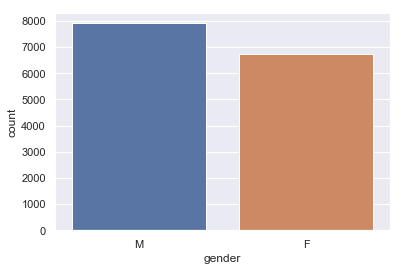

In [23]:
# Imputing values for gender
np.random.seed(0)
X_cat.loc[:, 'gender'] = X_cat['gender'].fillna(pd.Series(np.random.choice(['M', 'F'], 
                                                      p=[0.54, 0.46], size=len(X_cat))))
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


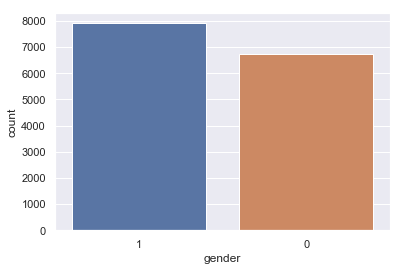

In [24]:
# Encoding gender as 1 and 0
X_cat.loc[:, 'gender'] = X_cat['gender'].replace({'F': 0, 'M': 1})
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

In [25]:
# Comparing unequal values of hospital_admit_source and icu_admit_source
X_cat[X_cat['hospital_admit_source']!=X_cat['icu_admit_source']]

,bmi,elective_surgery,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,Overweight,0,African American,1,Emergency Department,Floor,admit,SICU,Range[21 to 25],0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
1,Normal Weight,0,Caucasian,0,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
2,Overweight,0,Caucasian,1,Emergency Department,Floor,admit,Cardiac ICU,Range[5 to 10],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
3,Obese,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,MICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,Normal Weight,0,Caucasian,0,Emergency Department,Other ICU,transfer,Neuro ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
5,Normal Weight,0,Caucasian,0,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,Range[- to 0],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
6,Obese,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
7,Obese,0,Caucasian,0,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
8,Normal Weight,0,Asian,1,Emergency Department,Accident & Emergency,admit,Neuro ICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
9,Normal Weight,1,African American,1,NaN,Operating Room / Recovery,admit,CCU-CTICU,Range[1 to 5],1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular


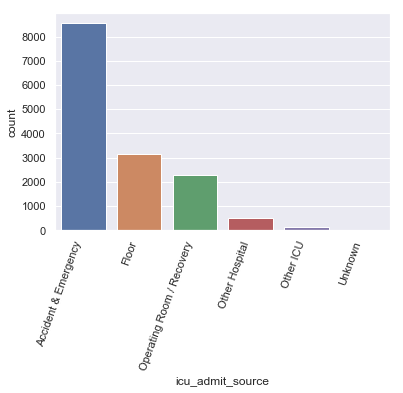

In [26]:
# Dropping hospital_admit_source and imputing missing values for icu_admit_source
X_cat = X_cat.drop(columns = 'hospital_admit_source', axis=1)
X_cat.loc[:, 'icu_admit_source'] = X_cat['icu_admit_source'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['icu_admit_source'], order = X_cat['icu_admit_source'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [27]:
# Comparing unequal values of apache_3j_bodysystem and apache_2_bodysystem
X_cat[X_cat['apache_3j_bodysystem']!=X_cat['apache_2_bodysystem']]

,bmi,elective_surgery,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
4,Normal Weight,0,Caucasian,0,Other ICU,transfer,Neuro ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
8,Normal Weight,0,Asian,1,Accident & Emergency,admit,Neuro ICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
11,Obese,0,Caucasian,0,Floor,transfer,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
15,Underweight,0,Caucasian,0,Accident & Emergency,admit,Cardiac ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
16,Overweight,0,Native American,1,Floor,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
17,Normal Weight,1,Caucasian,1,Operating Room / Recovery,admit,CCU-CTICU,Range[1 to 5],1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Musculoskeletal/Skin,Undefined diagnoses
19,Normal Weight,0,Caucasian,1,Accident & Emergency,admit,Neuro ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
21,Normal Weight,0,Caucasian,1,Other ICU,transfer,MICU,Range[1 to 5],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,Obese,0,African American,0,Operating Room / Recovery,admit,Med-Surg ICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gynecological,Renal/Genitourinary
23,Overweight,0,Caucasian,1,Accident & Emergency,admit,Neuro ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


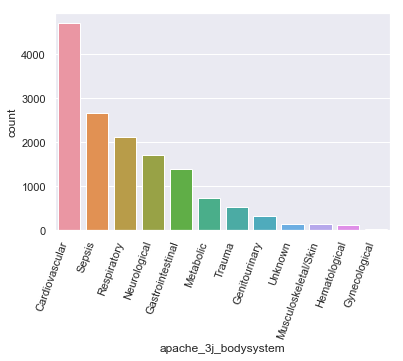

In [28]:
# Dropping apache_2_bodysystem and imputing missing values for apache_3j_bodysystem
X_cat = X_cat.drop(columns = 'apache_2_bodysystem', axis=1)
X_cat.loc[:, 'apache_3j_bodysystem'] = X_cat['apache_3j_bodysystem'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['apache_3j_bodysystem'], order = X_cat['apache_3j_bodysystem'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [29]:
X_cat.isnull().sum()

bmi                             0
elective_surgery                0
ethnicity                       0
gender                          0
icu_admit_source                0
icu_stay_type                   0
icu_type                        0
pre_icu_los_days                0
apache_post_operative           0
arf_apache                     59
gcs_unable_apache              89
intubated_apache               59
ventilated_apache              59
aids                           59
cirrhosis                      59
diabetes_mellitus              59
hepatic_failure                59
immunosuppression              59
leukemia                       59
lymphoma                       59
solid_tumor_with_metastasis    59
apache_3j_bodysystem            0
dtype: int64

In [30]:
# Obtaining the index values of rows where arf_apache is NaN
idx = X_cat.index[X_cat['arf_apache'].isnull()].tolist()

# Dropping rows from X_cat
X_cat = X_cat.drop(X_cat.index[idx]).reset_index(drop=True)
print("The shape of X_cat after dropping rows is {}".format(X_cat.shape))

# Dropping rows from X_num
X_num = final_X[num_col]
X_num = X_num.drop(X_num.index[idx]).reset_index(drop=True)
print("The shape of X_num after dropping rows is {}".format(X_num.shape))

# Dropping corresponding rows from y
final_y = final_y.drop(final_y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

The shape of X_cat after dropping rows is (14577, 22)
The shape of X_num after dropping rows is (14577, 118)
The shape of y after dropping rows is (14577,)


In [31]:
X_cat.isnull().sum()

bmi                             0
elective_surgery                0
ethnicity                       0
gender                          0
icu_admit_source                0
icu_stay_type                   0
icu_type                        0
pre_icu_los_days                0
apache_post_operative           0
arf_apache                      0
gcs_unable_apache              30
intubated_apache                0
ventilated_apache               0
aids                            0
cirrhosis                       0
diabetes_mellitus               0
hepatic_failure                 0
immunosuppression               0
leukemia                        0
lymphoma                        0
solid_tumor_with_metastasis     0
apache_3j_bodysystem            0
dtype: int64

In [32]:
# Dropping gcs_unable_apache
X_cat = X_cat.drop(columns = 'gcs_unable_apache', axis=1)
X_cat.isnull().sum()

bmi                            0
elective_surgery               0
ethnicity                      0
gender                         0
icu_admit_source               0
icu_stay_type                  0
icu_type                       0
pre_icu_los_days               0
apache_post_operative          0
arf_apache                     0
intubated_apache               0
ventilated_apache              0
aids                           0
cirrhosis                      0
diabetes_mellitus              0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
dtype: int64

### Dealing with numerical variables

In [33]:
# Removing columns with more than len(X_num)-5000.
X_num_nonan = X_num.dropna(thresh=len(X_num) - 5000, axis=1)

# Concatenating the numerical and categorical features 
tmp = pd.concat([X_num_nonan, X_cat], axis=1)

# One-hot encoding the dataset
new_dataset = pd.get_dummies(tmp)
new_dataset.head()

,age,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,resprate_apache,sodium_apache,temp_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,elective_surgery,gender,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,bmi_Normal Weight,bmi_Obese,bmi_Overweight,bmi_Underweight,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_admit_source_Unknown,icu_stay_type_admit,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CCU-CTICU,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,pre_icu_los_days_Range[- to 0],pre_icu_los_days_Range[1 to 5],pre_icu_los_days_Range[11 to 15],pre_icu_los_days_Range[16 to 20],pre_icu_los_days_Range[21 to 25],pre_icu_los_days_Range[25 to 30],pre_icu_los_days_Range[5 to 10],pre_icu_los_days_Range[> 30],apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,apache_3j_bodysystem_Unknown
0,82.0,108.0,203.01,121.0,3.47,3.0,1.0,3.0,169.0,131.0,20.4,41.0,38.0,145.0,36.70,5.3,68.0,31.0,68.0,31.0,131.0,110.0,77.0,41.0,77.0,41.0,38.0,23.0,100.0,94.0,126.0,63.0,126.0,63.0,38.40,36.70,68.0,56.0,68.0,56.0,120.0,112.0,74.0,66.0,74.0,66.0,35.0,24.0,100.0,100.0,106.0,93.0,106.0,93.0,NaN,NaN,121.0,113.09,7.5,7.5,3.47,3.47,169.0,169.0,15.0,15.0,6.8,6.4,20.4,20.4,107.0,107.0,4.4,4.4,145.0,145.0,5.3,5.3,0.81,0.54,0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,NaN,117.0,106.01,24.0,1.18,4.0,6.0,5.0,85.0,137.0,39.1,126.0,28.0,142.0,36.30,6.4,104.0,48.0,104.0,48.0,137.0,25.0,113.0,59.0,113.0,59.0,27.0,15.0,100.0,78.0,152.0,79.0,152.0,79.0,37.00,36.30,103.0,97.0,103.0,97.0,134.0,99.0,113.0,107.0,113.0,107.0,26.0,24.0,100.0,88.0,152.0,129.0,152.0,129.0,36.90,36.90,24.0,24.00,8.8,8.8,1.18,1.18,85.0,85.0,31.0,31.0,12.5,12.5,39.1,39.1,128.0,128.0,3.7,3.7,142.0,142.0,6.4,6.4,0.07,0.02,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,80.0,117.0,106.01,40.0,1.40,4.0,6.0,4.0,136.0,139.0,36.4,50.0,37.0,134.0,36.33,10.9,91.0,38.0,91.0,38.0,130.0,68.0,1

In [34]:
# Creating the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(new_dataset, 
                                                    final_y, 
                                                    test_size=0.2, 
                                                    stratify=final_y, 
                                                    random_state=42)

In [35]:
# Just as a sanity check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(11661, 141)
(11661,)
(2916, 141)
(2916,)


In [36]:
# Creating an imputer object with the strategy of using the mean
imp = Imputer(strategy="mean")

# Fitting and transforming the training set
X_train_imp = imp.fit_transform(X_train)

# Transforming the testing set with the imputing object created based on the training set
X_test_imp = imp.transform(X_test)

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../anaconda3/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


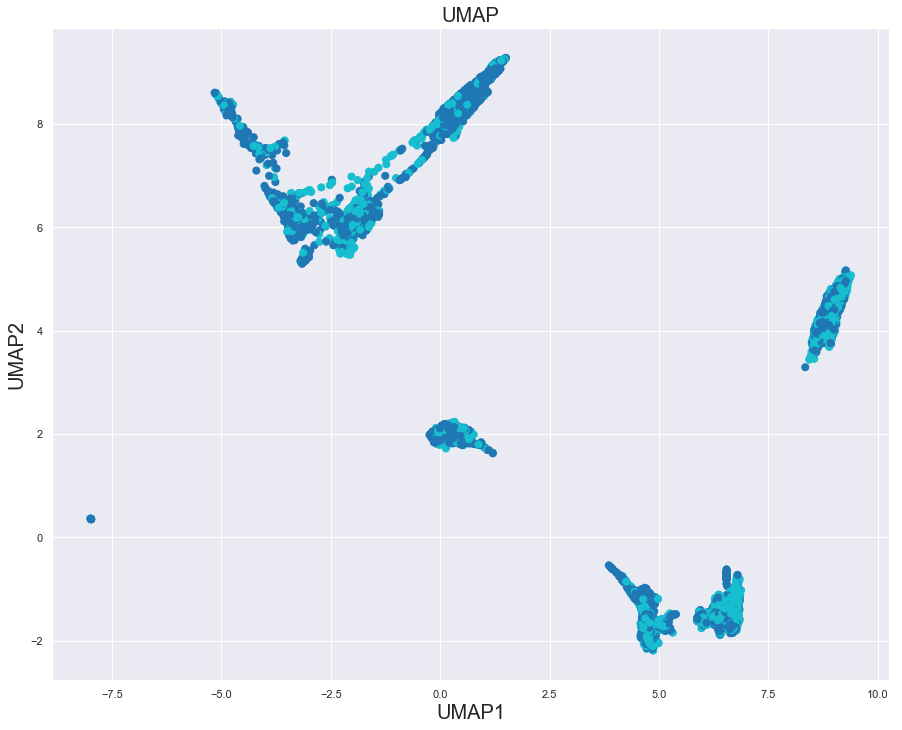

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../anaconda3/lib/python3.6/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../anaconda3/

In [67]:
# UMAP - Uniform Manifold Approximation and Projection

plt.figure(figsize=(15,12))
model = UMAP(n_neighbors = 4, min_dist = 0.25, n_components = 13)
X_umap = model.fit_transform(X_train_imp)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c = y_train.astype(int), cmap = 'tab10', s = 50)
plt.title('UMAP', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
plt.show()

X_test_umap = model.transform(X_test_imp)


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


1 depth
AUC Train:  0.8821058225768503
AUC Validation:  0.6893195936426096
 
2 depth
AUC Train:  0.8781301555178194
AUC Validation:  0.6802123050361879
 
3 depth


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9506870611384072
AUC Validation:  0.7445252538557615
 
4 depth


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9508756978233576
AUC Validation:  0.7408775400277083
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


5 depth
AUC Train:  0.9720412192557503
AUC Validation:  0.7695156688455415
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


6 depth
AUC Train:  0.9728228590773208
AUC Validation:  0.7636390579169833
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


7 depth
AUC Train:  0.9823346929294822
AUC Validation:  0.7749599546505528
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


8 depth
AUC Train:  0.9833270763317131
AUC Validation:  0.7718203051679082
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


9 depth
AUC Train:  0.9883352369091435
AUC Validation:  0.7732765210764379
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


10 depth
AUC Train:  0.9893961914010618
AUC Validation:  0.7680199368212577
 
20 depth
AUC Train:  0.9979476769932787
AUC Validation:  0.7860362278104073
 
50 depth
AUC Train:  0.9998284840247011
AUC Validation:  0.7911260446485064
 
75 depth
AUC Train:  1.0
AUC Validation:  0.7941582008877014
 


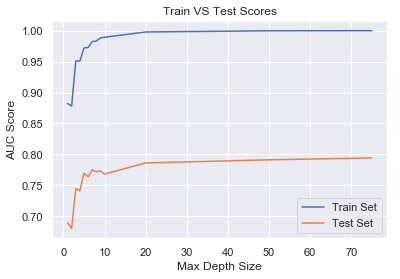

In [37]:
# Broad search
# Testing various max_depth_size levels for Random Forest and assessing with AUC
results  =  []
results2 = []
max_depth_size  = [1,2,3,4,5,6,7,8,9,10,20,50,75]

for depth in max_depth_size:
    model = RandomForestClassifier(depth, oob_score=True, n_jobs=-1, random_state=44)
    #model.fit(X, y)
    model.fit(X_train_imp, y_train)
    print(depth, 'depth')
    # Predicting on training and testing sets
    pred = model.predict(X_train_imp)
    pred2 = model.predict(X_test_imp)
    # Generating the ROC score
    roc1 = roc_auc_score(y_train, pred)
    roc2 = roc_auc_score(y_test, pred2)
    print('AUC Train: ', roc1)
    print('AUC Validation: ', roc2)
    # Appending results to the proper lists
    results.append(roc1)
    results2.append(roc2)
    print (" ")

# Plotting the results AUC score against the max_depth_size
plt.plot(max_depth_size, results, label='Train Set')
plt.plot(max_depth_size, results2, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('AUC Score')
plt.title('Train VS Test Scores')
plt.legend(loc="lower right")
plt.show()

auto max_features
AUC:  0.796844181459566
 
log2 max_features
AUC:  0.7972729611525599
 
0.3 max_features
AUC:  0.7971014492753623
 
0.5 max_features
AUC:  0.7953005745647886
 
0.7 max_features
AUC:  0.7959866220735786
 


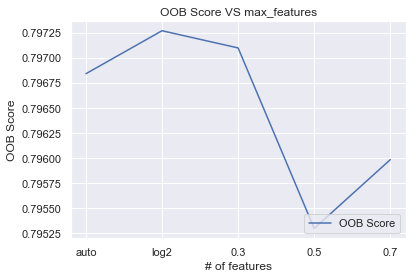

In [38]:
# Broad search
# Testing various max_features_options for Random Forest and assessing with AUC
results = []
max_features_options = ["auto", "log2", 0.3, 0.5, 0.7]

for features in max_features_options:
    model = RandomForestClassifier(max_features=features, oob_score=True, random_state=42, max_depth=150, n_estimators=500)
    #model.fit(X, y)
    model.fit(X_train_imp, y_train)
    print(features, 'max_features')
    AUC = model.oob_score_
    print('AUC: ', AUC)
    results.append(AUC)
    print (" ")
    
plt.plot(max_features_options, results, label='OOB Score')
plt.xlabel('# of features')
plt.ylabel('OOB Score')
plt.title('OOB Score VS max_features')
plt.legend(loc="lower right")
plt.show()


In [50]:
roc_auc_score(y_test, model.predict(X_test_imp))

0.7931738262184723

1 min samples
AUC:  0.7918703370208386
 
2 min samples
AUC:  0.7921276048366349
 
4 min samples
AUC:  0.7936712117314124
 
5 min samples
AUC:  0.7928136523454249
 
10 min samples
AUC:  0.7947002829945974
 
15 min samples
AUC:  0.7938427236086099
 
20 min samples
AUC:  0.7935854557928137
 


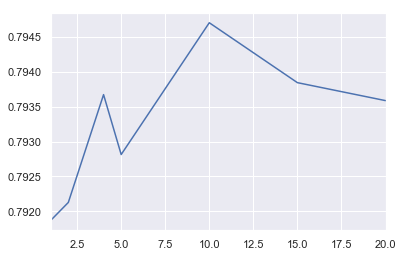

In [39]:
# Broad search
# Testing various min_samples_leaf_options for Random Forest and assessing with AUC
results = []
min_samples_leaf_options = [1, 2, 4, 5, 10, 15, 20]

for min_samples in min_samples_leaf_options:
    model = RandomForestClassifier(n_estimators=500, max_depth=9, max_features=0.3, oob_score=True, random_state=42, min_samples_leaf=min_samples)
    model.fit(X_train_imp, y_train)
    print(min_samples, "min samples")
    auc = model.oob_score_
    print('AUC: ', auc)
    results.append(auc)
    print (" ")
    
pd.Series(results, min_samples_leaf_options).plot()

In [41]:
# From hyper-parameters previously identified, 
# we will perform gridsearch with a finer range to find the optimal values  

parameters = {"max_depth": [90, 100, 110, 120], 
            "max_features": [0.3], 
            "min_samples_leaf": [8,9,10,11,12]}

model_rf = RandomForestClassifier(random_state=42, n_estimators=500)


# fbeta_score scoring object using make_scorer()
scorer = make_scorer(f1_score)


# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model_rf, param_grid=parameters, scoring=scorer)


# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train_imp, y_train)


# Get the estimator
best_clf = grid_fit.best_estimator_


# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_test_imp)


# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the validation data: {:.4f}".format(f1_score(y_test, best_predictions)))
print(best_clf)

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



Optimized Model
------
Final accuracy score on the validation data: 0.7888
Final F-score on the validation data: 0.7895
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features=0.3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [46]:
# Re-creation of the optimal model
model_rf = RandomForestClassifier(random_state=42, 
                                  n_estimators=500, 
                                  max_depth=90, 
                                  max_features=0.3,
                                  min_samples_leaf=8,
                                  min_samples_split=2)

# Prediction on the testing dataset
rf_model = model_rf.fit(X_train_imp, y_train)
y_pred = rf_model.predict(X_test_imp)

# Printing the confusion matrix
print(confusion_matrix(y_test, y_pred))
print('Accuracy score: {0:.2f}'.format(accuracy_score(y_test, y_pred)))

[[1145  306]
 [ 310 1155]]
Accuracy score: 0.79


For the Random Forest model with a down-sampled dataset, the accuracy is fairly low.
However, the distribution in the confusion matrix is well balanced showing that our model
is not inclined to choose the majority class (which of course was taken care of via the SMOTE
approach.

In [51]:
# Let's try to build a logistic regression model

# Standardization of training and test sets
scaler = StandardScaler()

# Fitting and transforming the training set for standardization
X_train_imp_sc = scaler.fit_transform(X_train_imp)

# Transforming the testing set with the standardization object
X_test_imp_sc = scaler.transform(X_test_imp)


In [52]:
# Function to create, train, and assess a model
def model_building(dict_params, model_obj, X_data, y_data, X_toPredict, y_toPredict):

    parameters = dict_params

    # model as an object
    model = model_obj

    # fbeta_score scoring object using make_scorer()
    scorer = make_scorer(f1_score)

    # Grid Search on the classifier using 'scorer' as the scoring method
    grid_obj = GridSearchCV(model, param_grid=dict_params, scoring=scorer)

    # Fit the grid search object to the training data and find the optimal parameters using fit()
    grid_fit = grid_obj.fit(X_data, y_data)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the model
    best_predictions = best_clf.predict(X_toPredict)
    
    # Give the probability from the predictions
    best_predictions_prob = best_clf.predict_proba(X_toPredict)[:,1]
    
    # Report the scores
    print("\nOptimized Model\n------")
    print("Final accuracy score on the data: {:.4f}".format(accuracy_score(y_toPredict, best_predictions)))
    print("Final F1-score on the data: {:.4f}".format(f1_score(y_toPredict, best_predictions)))
    print(best_clf)
    
    return(best_clf, best_predictions, best_predictions_prob)


In [53]:
# Aplying the previous function with the Logistic Regression model
dict_params = {"C": [0.001, 0.01, 0.1, 1, 10 , 100, 1000]}
lr_model = LogisticRegression(random_state=42, penalty="l2")

lr_model_training, train_predictions, train_predictions_prob = model_building(dict_params=dict_params, 
               model_obj=lr_model,
               X_data=X_train_imp_sc, 
               y_data=y_train,
               X_toPredict=X_train_imp_sc,
               y_toPredict=y_train)

lr_model_validation, test_predictions, test_predictions_prob = model_building(dict_params=dict_params, 
               model_obj=lr_model,
               X_data=X_train_imp_sc, 
               y_data=y_train,
               X_toPredict=X_test_imp_sc,
               y_toPredict=y_test)


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/je


Optimized Model
------
Final accuracy score on the data: 0.7968
Final F1-score on the data: 0.7952
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/je


Optimized Model
------
Final accuracy score on the data: 0.7905
Final F1-score on the data: 0.7911
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [54]:
# Aplying the previous function with the Logistic Regression model with a fine-tuned parameters
parameters = {"C": [0.1, 0.4, 0.7, 1, 1.3, 1.7, 2]}
lr_model = LogisticRegression(random_state=42, penalty="l2")

lr_model_validation_finetuned, best_test_predictions, best_test_predictions_prob = model_building(dict_params=parameters, 
               model_obj=lr_model,
               X_data=X_train_imp_sc, 
               y_data=y_train,
               X_toPredict=X_test_imp_sc,
               y_toPredict=y_test)

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/je


Optimized Model
------
Final accuracy score on the data: 0.7905
Final F1-score on the data: 0.7911
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [55]:
# Function to generate the confusion matrix and
# extract precision and recall from model
def conf_matrix_with_metrics(true_predictions, predictions):
    confmat = confusion_matrix(true_predictions, predictions)
    print("The Confusion Matrix:\n", confmat)
    print("Accuracy Score:", round(accuracy_score(true_predictions, predictions), 2))
    print("Precision Score:", round(precision_score(true_predictions, predictions), 2))
    print("Recall Score:", round(recall_score(true_predictions, predictions), 2))
    print("AUC Score:", round(roc_auc_score(true_predictions, predictions),2))
conf_matrix_with_metrics(y_train, train_predictions)

The Confusion Matrix:
 [[4690 1112]
 [1258 4601]]
Accuracy Score: 0.8
Precision Score: 0.81
Recall Score: 0.79
AUC Score: 0.8


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


age                              0.011157
apache_2_diagnosis               0.012591
apache_3j_diagnosis              0.015630
bun_apache                       0.011252
creatinine_apache                0.010125
gcs_eyes_apache                  0.016392
gcs_motor_apache                 0.016380
gcs_verbal_apache                0.040782
glucose_apache                   0.009178
heart_rate_apache                0.011511
hematocrit_apache                0.007208
map_apache                       0.007163
resprate_apache                  0.010196
sodium_apache                    0.007371
temp_apache                      0.009730
wbc_apache                       0.009321
d1_diasbp_max                    0.006486
d1_diasbp_min                    0.015081
d1_diasbp_noninvasive_max        0.007207
d1_diasbp_noninvasive_min        0.014360
d1_heartrate_max                 0.010852
d1_heartrate_min                 0.010213
d1_mbp_max                       0.007037
d1_mbp_min                       0

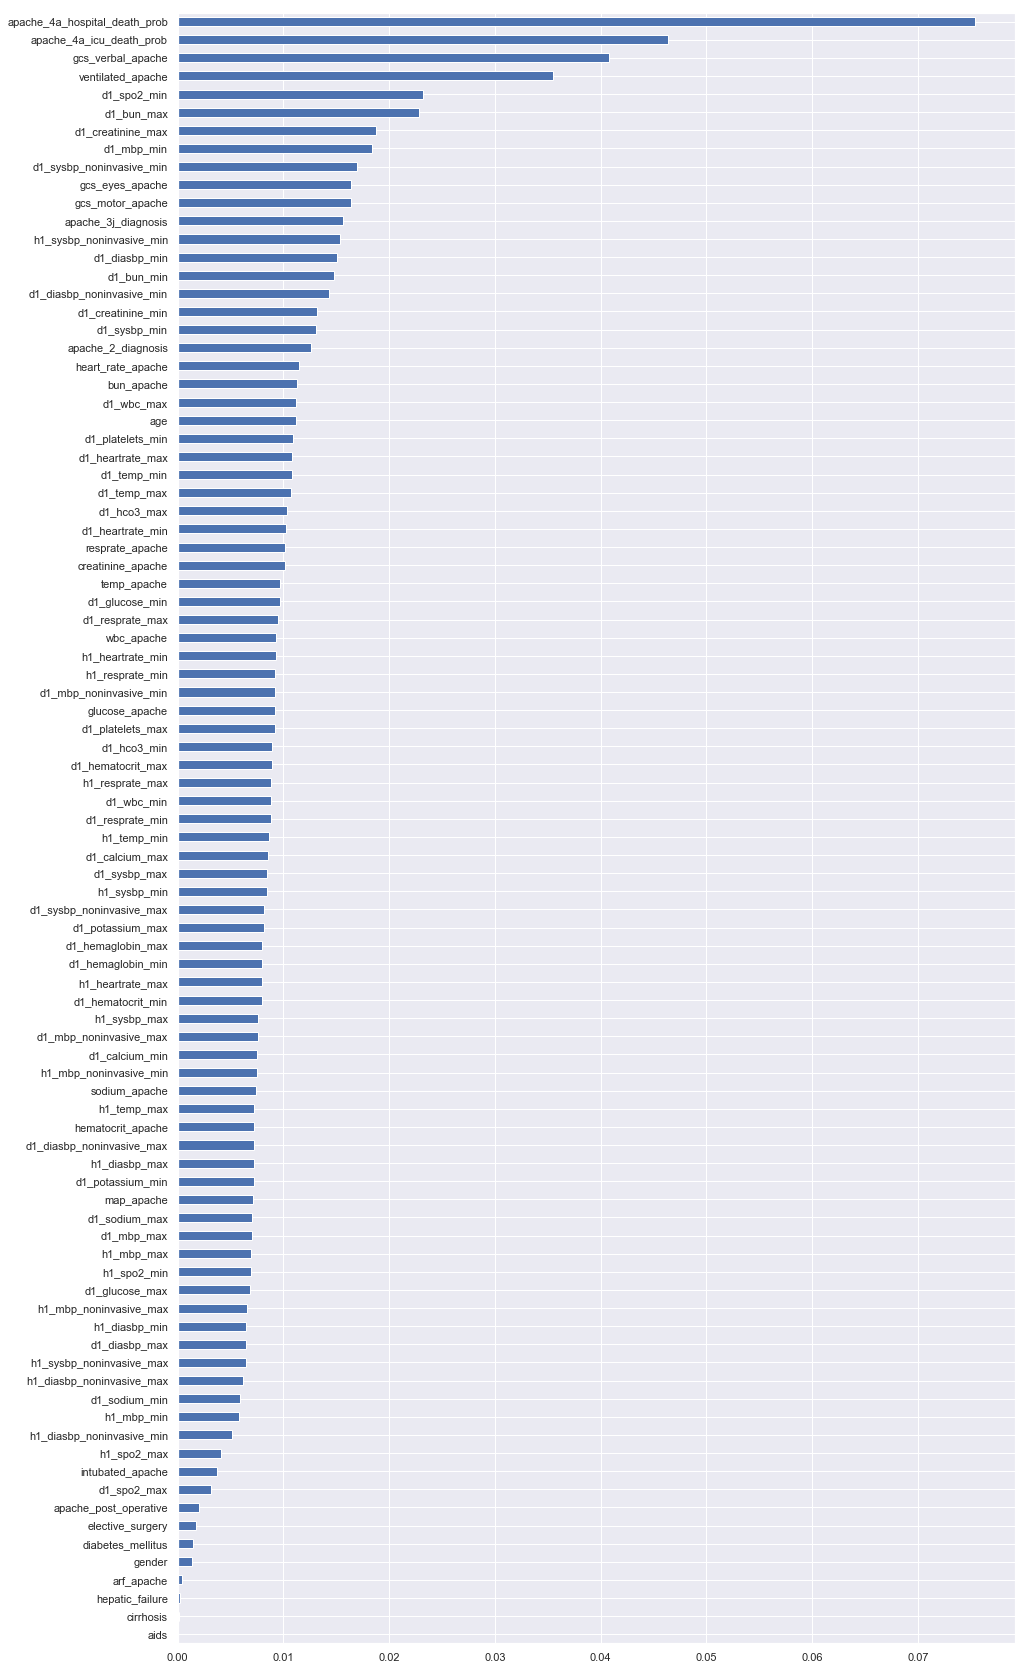

In [56]:
#Generating the random forest feature importances
from sklearn.ensemble import RandomForestClassifier

# Fitting the random forest classifier
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_imp_sc, y_train)

# Extracting feature importances from our model
feature_importances = pd.Series(model_rf.feature_importances_, index=new_dataset.columns)

# Extracting the most important first 90 features
sub_feature_importances = feature_importances[:90]
print(sub_feature_importances)


sub_feature_importances.sort_values(inplace=True)
sub_feature_importances.plot(kind='barh', figsize=(15,30))

In [57]:
# Now we are going to try Gradient Boosting
# Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42, n_estimators=500, max_features='auto')
    
#model.fit(X, y)
model.fit(X_train_imp_sc, y_train)
y_pred = model.predict(X_train_imp_sc)
print('accuracy score: ', round(accuracy_score(y_train, y_pred),2 ))
print('confusion matrix: ', confusion_matrix(y_train, y_pred))
print('AUC Score:', roc_auc_score(y_train, y_pred),2)


accuracy score:  0.89
confusion matrix:  [[5191  611]
 [ 620 5239]]
AUC Score: 0.8944356899372412 2


In [58]:
#model.fit(X, y)
y_pred = model.predict(X_test_imp_sc)
print('accuracy score: ',round(accuracy_score(y_test, y_pred), 2))
print('confusion matrix: ', confusion_matrix(y_test, y_pred))
print('AUC Score:', round(roc_auc_score(y_test, y_pred),2))

accuracy score:  0.81
confusion matrix:  [[1141  310]
 [ 251 1214]]
AUC Score: 0.81


In [67]:
#########################################
## Now we will replicate the same approaches but with an upsampled dataset
#########################################

In [68]:
X = data.drop('hospital_death', axis = 1)
y = data['hospital_death']
X.info()

# Obtaining the index values of rows where 50% or more of the data is missing
idx = X.index[X.isnull().mean(axis=1) > 0.5].tolist()

# Dropping rows from X
row_majority_X = X.drop(X.index[idx]).reset_index(drop=True)
print("The shape of X after dropping rows is {}".format(row_majority_X.shape))

# Dropping corresponding rows from y
final_y = y.drop(y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

row_majority_X.isnull().mean()

# Retain only those columns where missing values are less than 75%
column_majority_X = row_majority_X[row_majority_X.columns[row_majority_X.isnull().mean() < 0.75]]
column_majority_X.shape

# Drop columns based on manual evaluation of data
final_X = column_majority_X.drop(columns=['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'height', 'weight', 'readmission_status'], axis=1)
print("The shape of X after dropping columns is {}".format(final_X.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 185 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(7), object(8)
memory usage: 129.4+ MB
The shape of X after dropping rows is (84284, 185)
The shape of y after dropping rows is (84284,)
The shape of X after dropping columns is (84284, 133)


In [69]:
# Transforming BMI to a categorical variable
def BMICat(x) :
    try :
        x = float(x)
        if (x >= 0) and (x < 18.5) : return 'Underweight'
        elif ((x >= 18.5 ) and (x <= 24.9)) : return 'Normal Weight'
        elif ((x >= 25 )   and (x <= 29.9)) : return 'Overweight'
        else : return 'Obese'
    except ValueError:
        return 'Other'

final_X['bmi'] = final_X['bmi'].apply(BMICat)

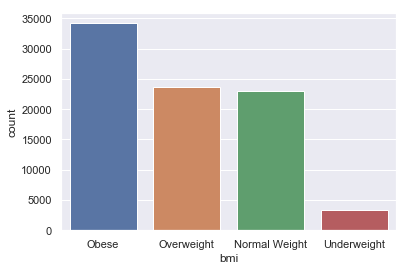

In [70]:
sns.set(style="darkgrid")
ax = sns.countplot(final_X['bmi'], order = final_X['bmi'].value_counts().index)
plt.show()

In [71]:
# Transforming pre_icu_los_days to a categorical variable
def PILDCat(x) :
    try :
        x = float(x)
        if (x <= 0)                : return 'Range[- to 0]'
        elif (x > 0) and (x <= 5) : return  'Range[1 to 5]'
        elif (x > 5) and (x <= 10) : return 'Range[5 to 10]'
        elif (x > 10) and (x <= 15) : return 'Range[11 to 15]'
        elif ((x > 15) and (x <= 20)) : return 'Range[16 to 20]'
        elif ((x > 20) and (x <= 25)) : return 'Range[21 to 25]'
        elif ((x > 25 ) and (x <= 30)) : return 'Range[25 to 30]'
               
        else : return 'Range[> 30]'
    except ValueError:
        return 'Other'

final_X['pre_icu_los_days']= final_X['pre_icu_los_days'].apply(PILDCat)

In [72]:
def num_cat_col(df):
    '''
    Splits the columns of the dataframe into categorical and numerical columns 
    and returns them as 2 separate lists.
    Columns having binary values (0 or 1) are added to the list of categorical columns.
    '''
    num_col = []
    cat_col = []
    dictionary = pd.read_csv('WiDS Datathon 2020 Dictionary.csv')
    new_dictionary = dictionary[dictionary['Data Type'] == 'binary']
    
    for column in df.columns:
        if df[column].dtypes == 'object':
            cat_col.append(column)
        elif column in [value for key, value in new_dictionary['Variable Name'].iteritems()]:
            cat_col.append(column)
        else:
            num_col.append(column)
    return cat_col, num_col

cat_col, num_col = num_cat_col(final_X)

In [73]:
X_cat = final_X[cat_col]
X_cat.isnull().sum()

bmi                                0
elective_surgery                   0
ethnicity                       1182
gender                            14
hospital_admit_source          19824
icu_admit_source                  85
icu_stay_type                      0
icu_type                           0
pre_icu_los_days                   0
apache_post_operative              0
arf_apache                       218
gcs_unable_apache                390
intubated_apache                 218
ventilated_apache                218
aids                             218
cirrhosis                        218
diabetes_mellitus                218
hepatic_failure                  218
immunosuppression                218
leukemia                         218
lymphoma                         218
solid_tumor_with_metastasis      218
apache_3j_bodysystem             935
apache_2_bodysystem              935
dtype: int64

In [74]:
# Value counts for ethnicity
print('The value counts for ethnicity are: \n{}'.format(X_cat['ethnicity'].value_counts()))

The value counts for ethnicity are: 
Caucasian           64997
African American     8730
Other/Unknown        4052
Hispanic             3518
Asian                1057
Native American       748
Name: ethnicity, dtype: int64


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


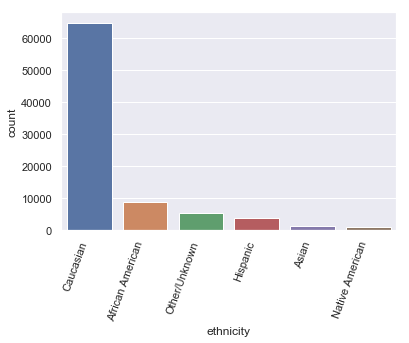

In [75]:
# Imputing values for ethnicity
X_cat.loc[:, 'ethnicity'] = X_cat['ethnicity'].fillna('Other/Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['ethnicity'], order = X_cat['ethnicity'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [76]:
# Percentage of gender classes
X_cat['gender'].value_counts(normalize=True)

M    0.542613
F    0.457387
Name: gender, dtype: float64

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


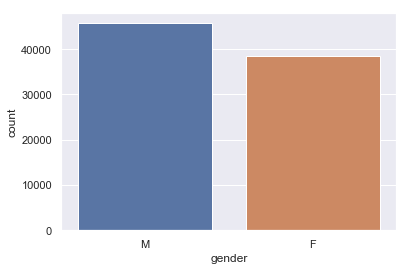

In [77]:
# Imputing values for gender
np.random.seed(0)
X_cat.loc[:, 'gender'] = X_cat['gender'].fillna(pd.Series(np.random.choice(['M', 'F'], 
                                                      p=[0.54, 0.46], size=len(X_cat))))
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


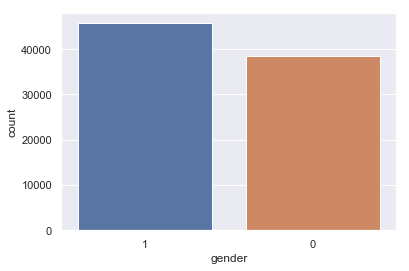

In [78]:
# Encoding gender as 1 and 0
X_cat.loc[:, 'gender'] = X_cat['gender'].replace({'F': 0, 'M': 1})
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

In [79]:
# Comparing unequal values of hospital_admit_source and icu_admit_source
X_cat[X_cat['hospital_admit_source']!=X_cat['icu_admit_source']]

,bmi,elective_surgery,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
2,Normal Weight,1,Caucasian,0,Operating Room,Operating Room / Recovery,admit,CTICU,Range[1 to 5],1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
3,Overweight,0,Caucasian,1,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
4,Obese,0,Caucasian,0,Operating Room,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
5,Obese,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Sepsis,Cardiovascular
7,Overweight,0,Other/Unknown,1,Direct Admit,Accident & Emergency,admit,CCU-CTICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
8,Overweight,1,Hispanic,0,Operating Room,Operating Room / Recovery,admit,Med-Surg ICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Respiratory,Respiratory
9,Overweight,1,Caucasian,0,Operating Room,Operating Room / Recovery,admit,Med-Surg ICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Neurological,Neurologic
10,Obese,1,Caucasian,1,Operating Room,Operating Room / Recovery,admit,Med-Surg ICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
11,Obese,1,Caucasian,1,Operating Room,Operating Room / Recovery,admit,MICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
12,Obese,0,Caucasian,0,Emergency Department,Accident & Emergency,admit,MICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular


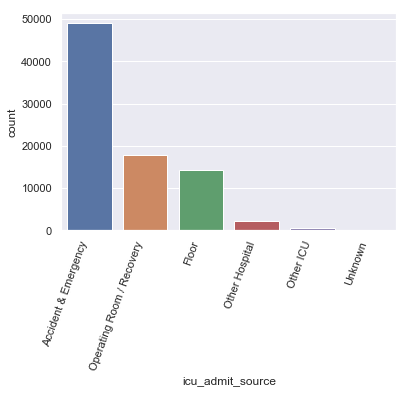

In [80]:
# Dropping hospital_admit_source and imputing missing values for icu_admit_source
X_cat = X_cat.drop(columns = 'hospital_admit_source', axis=1)
X_cat.loc[:, 'icu_admit_source'] = X_cat['icu_admit_source'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['icu_admit_source'], order = X_cat['icu_admit_source'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [81]:
# Comparing unequal values of apache_3j_bodysystem and apache_2_bodysystem
X_cat[X_cat['apache_3j_bodysystem']!=X_cat['apache_2_bodysystem']]

,bmi,elective_surgery,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,Normal Weight,0,Caucasian,1,Floor,admit,CTICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
3,Overweight,0,Caucasian,1,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
5,Obese,0,Caucasian,1,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Sepsis,Cardiovascular
9,Overweight,1,Caucasian,0,Operating Room / Recovery,admit,Med-Surg ICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Neurological,Neurologic
12,Obese,0,Caucasian,0,Accident & Emergency,admit,MICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
15,Overweight,0,Hispanic,1,Accident & Emergency,admit,Neuro ICU,Range[- to 0],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
17,Obese,0,Caucasian,1,Floor,admit,MICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
18,Obese,1,Caucasian,0,Operating Room / Recovery,admit,Med-Surg ICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Genitourinary,Renal/Genitourinary
19,Normal Weight,0,Caucasian,1,Floor,admit,MICU,Range[5 to 10],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
21,Overweight,0,Caucasian,0,Floor,admit,CCU-CTICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular


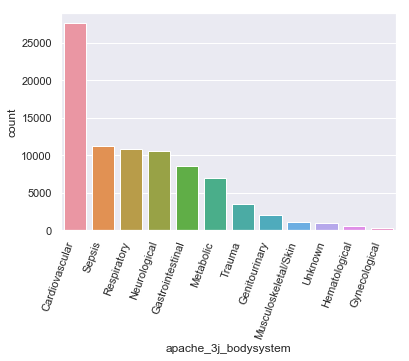

In [82]:
# Dropping apache_2_bodysystem and imputing missing values for apache_3j_bodysystem
X_cat = X_cat.drop(columns = 'apache_2_bodysystem', axis=1)
X_cat.loc[:, 'apache_3j_bodysystem'] = X_cat['apache_3j_bodysystem'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['apache_3j_bodysystem'], order = X_cat['apache_3j_bodysystem'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [83]:
# Obtaining the index values of rows where arf_apache is NaN
idx = X_cat.index[X_cat['arf_apache'].isnull()].tolist()

# Dropping rows from X_cat
X_cat = X_cat.drop(X_cat.index[idx]).reset_index(drop=True)
print("The shape of X_cat after dropping rows is {}".format(X_cat.shape))

# Dropping rows from X_num
X_num = final_X[num_col]
X_num = X_num.drop(X_num.index[idx]).reset_index(drop=True)
print("The shape of X_num after dropping rows is {}".format(X_num.shape))

# Dropping corresponding rows from y
final_y = final_y.drop(final_y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

The shape of X_cat after dropping rows is (84066, 22)
The shape of X_num after dropping rows is (84066, 109)
The shape of y after dropping rows is (84066,)


In [84]:
# Dropping gcs_unable_apache
X_cat = X_cat.drop(columns = 'gcs_unable_apache', axis=1)
X_cat.isnull().sum()

bmi                            0
elective_surgery               0
ethnicity                      0
gender                         0
icu_admit_source               0
icu_stay_type                  0
icu_type                       0
pre_icu_los_days               0
apache_post_operative          0
arf_apache                     0
intubated_apache               0
ventilated_apache              0
aids                           0
cirrhosis                      0
diabetes_mellitus              0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
dtype: int64

In [87]:
# Removing columns with more than len(X_num)-5000.
X_num_nonan = X_num.dropna(thresh=len(X_num) - 5000, axis=1)

# Concatenating the numerical and categorical features 
tmp = pd.concat([X_num_nonan, X_cat], axis=1)

# One-hot encoding the dataset
new_dataset = pd.get_dummies(tmp)
new_dataset.head()

,age,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,resprate_apache,sodium_apache,temp_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,elective_surgery,gender,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,bmi_Normal Weight,bmi_Obese,bmi_Overweight,bmi_Underweight,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_admit_source_Unknown,icu_stay_type_admit,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CCU-CTICU,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,pre_icu_los_days_Range[- to 0],pre_icu_los_days_Range[1 to 5],pre_icu_los_days_Range[11 to 15],pre_icu_los_days_Range[16 to 20],pre_icu_los_days_Range[21 to 25],pre_icu_los_days_Range[25 to 30],pre_icu_los_days_Range[5 to 10],pre_icu_los_days_Range[> 30],apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,apache_3j_bodysystem_Unknown
0,68.0,102.0,206.01,25.0,0.73,3.0,6.0,1.0,159.0,45.0,43.1,112.0,57.0,146.0,36.1,9.30,87.0,66.0,87.0,66.0,77.0,48.0,112.0,90.0,112.0,90.0,76.0,0.0,100.0,61.0,158.0,132.0,158.0,132.0,36.8,36.1,87.0,66.0,87.0,66.0,77.0,64.0,112.0,90.0,112.0,90.0,49.0,13.0,95.0,88.0,158.0,132.0,158.0,132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142.0,130.0,NaN,NaN,13.7,13.7,46.1,46.1,179.0,179.0,NaN,NaN,NaN,NaN,9.30,9.30,0.24,0.14,0,1,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,34.0,113.0,501.05,23.0,NaN,4.0,4.0,1.0,67.0,147.0,33.1,53.0,50.0,143.0,36.4,29.10,90.0,46.0,90.0,46.0,145.0,89.0,99.0,53.0,99.0,53.0,50.0,11.0,100.0,92.0,152.0,69.0,152.0,69.0,36.9,36.4,90.0,77.0,90.0,77.0,134.0,122.0,99.0,83.0,99.0,83.0,19.0,16.0,100.0,92.0,152.0,120.0,152.0,120.0,36.8,36.8,23.0,20.0,9.1,7.9,NaN,NaN,165.0,67.0,22.0,18.0,14.2,14.2,45.7,45.7,278.0,278.0,4.6,2.4,146.0,143.0,29.10,29.10,0.32,0.31,0,1,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,81.0,114.0,102.01,39.0,2.21,1.0,1.0,1.0,248.0,131.0,30.1,61.0,37.0,143.0,36.3,5.20,79.0,55.0,79.0,55.0,131.0,102.0,99.0,63.0,99.0,63.0,34.

In [86]:
# Creating the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(new_dataset, 
                                                    final_y, 
                                                    test_size=0.2, 
                                                    stratify=final_y, 
                                                    random_state=42)


In [87]:
# Just as a sanity check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(67252, 113)
(67252,)
(16814, 113)
(16814,)


In [88]:
# Creating an imputer object with the strategy of using the mean
imp = Imputer(strategy="mean")

# Fitting and transforming the training set
X_train_imp = imp.fit_transform(X_train)

# Transforming the testing set with the imputing object created based on the training set
X_test_imp = imp.transform(X_test)

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [59]:
# Upsampling training set
# Upsample using SMOTE
sm = SMOTE(random_state=42, ratio=1.0)
X_train_imp_sm, y_train_sm = sm.fit_sample(X_train_imp, y_train)


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


1 depth
AUC Train:  0.8784775558969108
AUC Validation:  0.7047504016295693
 
2 depth
AUC Train:  0.8773681515617001
AUC Validation:  0.6915080337674618
 
3 depth


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9488820617852876
AUC Validation:  0.7521128185104777
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


4 depth
AUC Train:  0.9481993514251579
AUC Validation:  0.7343863123701907
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


5 depth
AUC Train:  0.9703020993343574
AUC Validation:  0.7688660050853479
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


6 depth
AUC Train:  0.9726062467997952
AUC Validation:  0.7599144287921946
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


7 depth
AUC Train:  0.9829322409967571
AUC Validation:  0.7757084087001315
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


8 depth
AUC Train:  0.9829322409967571
AUC Validation:  0.7691031017798717
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


9 depth
AUC Train:  0.9890766342379246
AUC Validation:  0.7787767880454342
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


10 depth
AUC Train:  0.9885646014678273
AUC Validation:  0.7786297786862303
 
20 depth
AUC Train:  0.9978665301245945
AUC Validation:  0.7822885476180956
 
50 depth
AUC Train:  0.9998293224099677
AUC Validation:  0.7887303801309207
 
75 depth
AUC Train:  1.0
AUC Validation:  0.7944797397581519
 


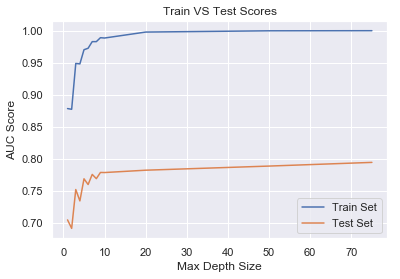

In [60]:
# Broad search
# Testing various max_depth_size levels for Random Forest and assessing with AUC
results  =  []
results2 = []
max_depth_size  = [1,2,3,4,5,6,7,8,9,10,20,50,75]

for depth in max_depth_size:
    model = RandomForestClassifier(depth, oob_score=True, n_jobs=-1, random_state=44)
    #model.fit(X, y)
    model.fit(X_train_imp_sm, y_train_sm)
    print(depth, 'depth')
    # Predicting on training and testing sets
    pred = model.predict(X_train_imp_sm)
    pred2 = model.predict(X_test_imp)
    # Generating the ROC score
    roc1 = roc_auc_score(y_train_sm, pred)
    roc2 = roc_auc_score(y_test, pred2)
    print('AUC Train: ', roc1)
    print('AUC Validation: ', roc2)
    # Appending results to the proper lists
    results.append(roc1)
    results2.append(roc2)
    print (" ")

# Plotting the results AUC score against the max_depth_size
plt.plot(max_depth_size, results, label='Train Set')
plt.plot(max_depth_size, results2, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('AUC Score')
plt.title('Train VS Test Scores')
plt.legend(loc="lower right")
plt.show()

In [62]:
# Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42, n_estimators=500, max_features='auto')
    
#model.fit(X, y)
model.fit(X_train_imp_sm, y_train_sm)
y_pred = model.predict(X_train_imp_sm)
print('accuracy score: ', round(accuracy_score(y_train_sm, y_pred),2 ))
print('confusion matrix: ', confusion_matrix(y_train_sm, y_pred))
print('AUC Score:', round(roc_auc_score(y_train_sm, y_pred),2))

accuracy score:  0.9
confusion matrix:  [[5256  603]
 [ 621 5238]]
AUC Score: 0.9


In [63]:
# Prediction on the test set
y_pred = model.predict(X_test_imp)
print(confusion_matrix(y_test, y_pred))
print('accuracy score: ',round(accuracy_score(y_test, y_pred), 2))
print('AUC Score:', round(roc_auc_score(y_test, y_pred),2))

[[1146  305]
 [ 245 1220]]
accuracy score:  0.81
AUC Score: 0.81


In [65]:
# Removing columns with more than len(X_num)-5000.
X_num_nonan = X_num.dropna(thresh=len(X_num) - 5000, axis=1)

# Concatenating the numerical and categorical features 
tmp = pd.concat([X_num_nonan, X_cat], axis=1)

# One-hot encoding the dataset
new_dataset = pd.get_dummies(tmp)
new_dataset.head()

,age,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,resprate_apache,sodium_apache,temp_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,elective_surgery,gender,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,bmi_Normal Weight,bmi_Obese,bmi_Overweight,bmi_Underweight,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_admit_source_Unknown,icu_stay_type_admit,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CCU-CTICU,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,pre_icu_los_days_Range[- to 0],pre_icu_los_days_Range[1 to 5],pre_icu_los_days_Range[11 to 15],pre_icu_los_days_Range[16 to 20],pre_icu_los_days_Range[21 to 25],pre_icu_los_days_Range[25 to 30],pre_icu_los_days_Range[5 to 10],pre_icu_los_days_Range[> 30],apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,apache_3j_bodysystem_Unknown
0,82.0,108.0,203.01,121.0,3.47,3.0,1.0,3.0,169.0,131.0,20.4,41.0,38.0,145.0,36.70,5.3,68.0,31.0,68.0,31.0,131.0,110.0,77.0,41.0,77.0,41.0,38.0,23.0,100.0,94.0,126.0,63.0,126.0,63.0,38.40,36.70,68.0,56.0,68.0,56.0,120.0,112.0,74.0,66.0,74.0,66.0,35.0,24.0,100.0,100.0,106.0,93.0,106.0,93.0,NaN,NaN,121.0,113.09,7.5,7.5,3.47,3.47,169.0,169.0,15.0,15.0,6.8,6.4,20.4,20.4,107.0,107.0,4.4,4.4,145.0,145.0,5.3,5.3,0.81,0.54,0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,NaN,117.0,106.01,24.0,1.18,4.0,6.0,5.0,85.0,137.0,39.1,126.0,28.0,142.0,36.30,6.4,104.0,48.0,104.0,48.0,137.0,25.0,113.0,59.0,113.0,59.0,27.0,15.0,100.0,78.0,152.0,79.0,152.0,79.0,37.00,36.30,103.0,97.0,103.0,97.0,134.0,99.0,113.0,107.0,113.0,107.0,26.0,24.0,100.0,88.0,152.0,129.0,152.0,129.0,36.90,36.90,24.0,24.00,8.8,8.8,1.18,1.18,85.0,85.0,31.0,31.0,12.5,12.5,39.1,39.1,128.0,128.0,3.7,3.7,142.0,142.0,6.4,6.4,0.07,0.02,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,80.0,117.0,106.01,40.0,1.40,4.0,6.0,4.0,136.0,139.0,36.4,50.0,37.0,134.0,36.33,10.9,91.0,38.0,91.0,38.0,130.0,68.0,1

In [66]:
# Creating new features from current features
new_dataset['temp_cat'] = [3 if i > 38 
                       else 1 if i < 36 
                       else 2
                       for i in new_dataset['temp_apache']]

new_dataset['d1_temp_max_cat'] = [3 if i > 38 
                       else 1 if i < 36 
                       else 2
                       for i in new_dataset['d1_temp_max']]

new_dataset['d1_temp_min_cat'] = [3 if i > 38 
                       else 1 if i < 36 
                       else 2
                       for i in new_dataset['d1_temp_min']]

new_dataset['h1_temp_max_cat'] = [3 if i > 38 
                       else 1 if i < 36 
                       else 2
                       for i in new_dataset['h1_temp_max']]

new_dataset['h1_temp_min_cat'] = [3 if i > 38 
                       else 1 if i < 36 
                       else 2
                       for i in new_dataset['h1_temp_min']]

new_dataset['h1_heartrate_max_cat'] = [3 if (i > 90) and (i < 100) 
                                        else 4 if i >= 100 
                                        else 3 if (i >= 70) and (i <= 90)
                                        else 2 if (i >= 60) and (i < 70)
                                        else 1 
                                        for i in new_dataset['h1_heartrate_max']]

new_dataset['h1_heartrate_min_cat'] = [3 if (i > 90) and (i < 100) 
                                        else 4 if i >= 100 
                                        else 3 if (i >= 70) and (i <= 90)
                                        else 2 if (i >= 60) and (i < 70)
                                        else 1 
                                        for i in new_dataset['h1_heartrate_min']]

new_dataset['d1_heartrate_max_cat'] = [3 if (i > 90) and (i < 100) 
                                        else 4 if i >= 100 
                                        else 3 if (i >= 70) and (i <= 90)
                                        else 2 if (i >= 60) and (i < 70)
                                        else 1
                                        for i in new_dataset['d1_heartrate_max']]

new_dataset['d1_heartrate_min_cat'] = [3 if (i > 90) and (i < 100) 
                                        else 4 if i >= 100 
                                        else 3 if (i >= 70) and (i <= 90)
                                        else 2 if (i >= 60) and (i < 70)
                                        else 1 
                                        for i in new_dataset['d1_heartrate_min']]

In [67]:
new_dataset.head()

,age,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,resprate_apache,sodium_apache,temp_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,elective_surgery,gender,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,bmi_Normal Weight,bmi_Obese,bmi_Overweight,bmi_Underweight,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_admit_source_Unknown,icu_stay_type_admit,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CCU-CTICU,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,pre_icu_los_days_Range[- to 0],pre_icu_los_days_Range[1 to 5],pre_icu_los_days_Range[11 to 15],pre_icu_los_days_Range[16 to 20],pre_icu_los_days_Range[21 to 25],pre_icu_los_days_Range[25 to 30],pre_icu_los_days_Range[5 to 10],pre_icu_los_days_Range[> 30],apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,apache_3j_bodysystem_Unknown,temp_cat,d1_temp_max_cat,d1_temp_min_cat,h1_temp_max_cat,h1_temp_min_cat,h1_heartrate_max_cat,h1_heartrate_min_cat,d1_heartrate_max_cat,d1_heartrate_min_cat
0,82.0,108.0,203.01,121.0,3.47,3.0,1.0,3.0,169.0,131.0,20.4,41.0,38.0,145.0,36.70,5.3,68.0,31.0,68.0,31.0,131.0,110.0,77.0,41.0,77.0,41.0,38.0,23.0,100.0,94.0,126.0,63.0,126.0,63.0,38.40,36.70,68.0,56.0,68.0,56.0,120.0,112.0,74.0,66.0,74.0,66.0,35.0,24.0,100.0,100.0,106.0,93.0,106.0,93.0,NaN,NaN,121.0,113.09,7.5,7.5,3.47,3.47,169.0,169.0,15.0,15.0,6.8,6.4,20.4,20.4,107.0,107.0,4.4,4.4,145.0,145.0,5.3,5.3,0.81,0.54,0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,3,2,2,2,4,4,4,4
1,NaN,117.0,106.01,24.0,1.18,4.0,6.0,5.0,85.0,137.0,39.1,126.0,28.0,142.0,36.30,6.4,104.0,48.0,104.0,48.0,137.0,25.0,113.0,59.0,113.0,59.0,27.0,15.0,100.0,78.0,152.0,79.0,152.0,79.0,37.00,36.30,103.0,97.0,103.0,97.0,134.0,99.0,113.0,107.0,113.0,107.0,26.0,24.0,100.0,88.0,152.0,129.0,152.0,129.0,36.90,36.90,24.0,24.00,8.8,8.8,1.18,1.18,85.0,85.0,31.0,31.0,12.5,12.5,39.1,39.1,128.0,128.0,3.7,3.7,142.0,142.0,6.4,6.4,0.07,0.02,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0

In [68]:
# Performing Label Encoding in order to encode the ordinal features previously created.
le = LabelEncoder()
cols = ['temp_cat', 'd1_temp_max_cat', 'd1_temp_min_cat', 'h1_temp_max_cat',
                   'h1_temp_min_cat', 'h1_heartrate_max_cat', 'h1_heartrate_min_cat',
                   'd1_heartrate_max_cat', 'd1_heartrate_min_cat', 'd1_heartrate_min']

df = new_dataset[cols].apply(LabelEncoder().fit_transform)

In [69]:
# Removing the original features, but could be avoided as well
new_df = new_dataset.drop(['temp_cat', 'd1_temp_max_cat', 'd1_temp_min_cat', 'h1_temp_max_cat',
                   'h1_temp_min_cat', 'h1_heartrate_max_cat', 'h1_heartrate_min_cat',
                   'd1_heartrate_max_cat', 'd1_heartrate_min_cat','apache_2_diagnosis'],axis=1)
result = pd.concat([new_df, df], axis=1)
new_dataset = result

In [70]:
new_dataset.head()

,age,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,resprate_apache,sodium_apache,temp_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,elective_surgery,gender,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,bmi_Normal Weight,bmi_Obese,bmi_Overweight,bmi_Underweight,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_admit_source_Unknown,icu_stay_type_admit,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CCU-CTICU,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,pre_icu_los_days_Range[- to 0],pre_icu_los_days_Range[1 to 5],pre_icu_los_days_Range[11 to 15],pre_icu_los_days_Range[16 to 20],pre_icu_los_days_Range[21 to 25],pre_icu_los_days_Range[25 to 30],pre_icu_los_days_Range[5 to 10],pre_icu_los_days_Range[> 30],apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,apache_3j_bodysystem_Unknown,temp_cat,d1_temp_max_cat,d1_temp_min_cat,h1_temp_max_cat,h1_temp_min_cat,h1_heartrate_max_cat,h1_heartrate_min_cat,d1_heartrate_max_cat,d1_heartrate_min_cat,d1_heartrate_min
0,82.0,203.01,121.0,3.47,3.0,1.0,3.0,169.0,131.0,20.4,41.0,38.0,145.0,36.70,5.3,68.0,31.0,68.0,31.0,131.0,110.0,77.0,41.0,77.0,41.0,38.0,23.0,100.0,94.0,126.0,63.0,126.0,63.0,38.40,36.70,68.0,56.0,68.0,56.0,120.0,112.0,74.0,66.0,74.0,66.0,35.0,24.0,100.0,100.0,106.0,93.0,106.0,93.0,NaN,NaN,121.0,113.09,7.5,7.5,3.47,3.47,169.0,169.0,15.0,15.0,6.8,6.4,20.4,20.4,107.0,107.0,4.4,4.4,145.0,145.0,5.3,5.3,0.81,0.54,0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,1,1,1,3,3,3,3,109
1,NaN,106.01,24.0,1.18,4.0,6.0,5.0,85.0,137.0,39.1,126.0,28.0,142.0,36.30,6.4,104.0,48.0,104.0,48.0,137.0,25.0,113.0,59.0,113.0,59.0,27.0,15.0,100.0,78.0,152.0,79.0,152.0,79.0,37.00,36.30,103.0,97.0,103.0,97.0,134.0,99.0,113.0,107.0,113.0,107.0,26.0,24.0,100.0,88.0,152.0,129.0,152.0,129.0,36.90,36.90,24.0,24.00,8.8,8.8,1.18,1.18,85.0,85.0,31.0,31.0,12.5,12.5,39.1,39.1,128.0,128.0,3.7,3.7,142.0,142.0,6.4,6.4,0.07,0.02,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0

In [71]:
# Creating the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(new_dataset, 
                                                    final_y, 
                                                    test_size=0.2, 
                                                    stratify=final_y, 
                                                    random_state=42)

#Creating an imputer object with the strategy of using the mean
imp = Imputer(strategy="mean")

# Fitting and transforming the training set
X_train_imp = imp.fit_transform(X_train)

# Transforming the testing set with the imputing object created based on the training set
X_test_imp = imp.transform(X_test)


# Let's try to build a logistic regression model
# Standardization of training and test sets
scaler = StandardScaler()

# Fitting and transforming the training set for standardization
X_train_imp_sc = scaler.fit_transform(X_train_imp)

# Transforming the testing set with the standardization object
X_test_imp_sc = scaler.transform(X_test_imp)


In [72]:
# Now we are going to try Gradient Boosting
# Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42, n_estimators=500, max_features='auto')
    
#model.fit(X, y)
model.fit(X_train_imp_sc, y_train)
y_pred = model.predict(X_train_imp_sc)
y_pred_prob = model.predict_proba(X_train_imp_sc)
print('Train set - accuracy score: ', round(accuracy_score(y_train, y_pred),2 ))
print('Train set - confusion matrix: ', confusion_matrix(y_train, y_pred))
print('AUC Score:', round(roc_auc_score(y_train, y_pred),2))

#model.fit(X, y)
y_pred = model.predict(X_test_imp_sc)
y_pred_prob = model.predict_proba(X_test_imp_sc)
print('Test Set - accuracy score: ',round(accuracy_score(y_test, y_pred), 2))
print('Test Set - confusion matrix: ', confusion_matrix(y_test, y_pred))
print('AUC Score:', round(roc_auc_score(y_test, y_pred),2))

Train set - accuracy score:  0.89
Train set - confusion matrix:  [[5202  600]
 [ 625 5234]]
AUC Score: 0.89
Test Set - accuracy score:  0.81
Test Set - confusion matrix:  [[1142  309]
 [ 244 1221]]
AUC Score: 0.81
